In [120]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [121]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle

#import mapfxn as mf
#reload(mf)

plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

### Notebook purpose: QAQC some met office data, one year
#### (step D in pipeline from 'getting things from met office' > 'running PlankTOM12')

    googledoc for tracking the pipeline: 
    https://docs.google.com/spreadsheets/d/1jgaO3aba-2NpNWxJpHXdZx1mjblFmQFfLgAY1DpZM3U/edit#gid=0

    Steps overview:
        a) copy files Jasmin > Ada 
        b) symlinking to TJ's directory (to enable processing into model-compatible format)  
        c) processing 
        d) quality-control & visualisation 
        e) run a model!  							


## About the forcing files:

Variable key from DW: 
    16 – air temp
    17 – specific humidity
    18 – short wave rad
    19 – long wave rad
    20 – total precipitation
    21 – snow precipitation
    22 – wind speeds

    Files to check (made by TJ using DW's makeForcingData.py - step C): 
        (base) [mep22dku@c0078 ~/scratch/MET_soft/hist/u-bc370_hist]$ ls *1950*met_daily.nc
        -rw-r--r-- 1 mep22dku env 39955978 May 19 07:11 bulk_1950_16_met_daily.nc
        -rw-r--r-- 1 mep22dku env 39955978 May 19 07:14 bulk_1950_17_met_daily.nc
        -rw-r--r-- 1 mep22dku env 39955978 May 19 07:18 bulk_1950_18_met_daily.nc
        -rw-r--r-- 1 mep22dku env 39955978 May 19 07:22 bulk_1950_19_met_daily.nc
        -rw-r--r-- 1 mep22dku env 39955978 May 19 07:25 bulk_1950_20_met_daily.nc
        -rw-r--r-- 1 mep22dku env 39955978 May 19 07:29 bulk_1950_21_met_daily.nc
        -rw-r--r-- 1 mep22dku env   335164 May 19 07:43 bulk_1950_22_met_daily.nc

    Original files (made by Kat, I believe):
        (base) [mep22dku@c0078 /gpfs/data/greenocean/software/products/MetOffice/withOzone]$ ls *1950*
        -rw-r--r-- 1 ehw18seu greenocean  79403908 Jul 13  2021 MetOffice_lw_down1950.nc
        -rw-r--r-- 1 ehw18seu greenocean  79403900 Jul 13  2021 MetOffice_precip1950.nc
        -rw-r--r-- 1 ehw18seu greenocean  79403896 Jul 13  2021 MetOffice_qair10m1950.nc
        -rw-r--r-- 1 ehw18seu greenocean  79403888 Jul 13  2021 MetOffice_snow1950.nc
        -rw-r--r-- 1 ehw18seu greenocean  79403908 Jul 13  2021 MetOffice_sw_down1950.nc
        -rw-r--r-- 1 ehw18seu greenocean  79403884 Jul 13  2021 MetOffice_tair10m1950.nc
        -rw-r--r-- 1 ehw18seu greenocean 158588788 Jul 13  2021 MetOffice_wind1950.nc
    
Plan:
    check visually for year 1950, do a mins, means, maxes for SO (south of 30)

In [122]:
def plot_comps(Met_new, Met_orig, vnam, yr, adj, tvmin, tvmax, diffmin, diffmax, tcmap):

    Met_new_v = (Met_new[newvar][:,:,:]) - adj
    Met_orig_v =(Met_orig[origvar][:,:,:]) - adj

    #yearly means
    origmean = np.nanmean(Met_orig_v,axis =0)
    newmean = np.nanmean(Met_new_v,axis =0)

    fig = plt.figure(figsize = (12, 6))
    ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=2)
    w = ax1.pcolormesh(origmean, vmin = tvmin, cmap = tcmap, vmax = tvmax); plt.colorbar(w)
    ax2 = plt.subplot2grid((3, 3), (0, 1), rowspan=2)
    w = ax2.pcolormesh(newmean, vmin = tvmin, cmap = tcmap, vmax = tvmax); plt.colorbar(w)
    ax3 = plt.subplot2grid((3, 3), (0, 2), rowspan=2)
    w = ax3.pcolormesh(origmean-newmean, cmap = cm.balance, vmin = diffmin, vmax = diffmax); plt.colorbar(w)
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=3)

    newcol = 'r'; origcol = 'cornflowerblue'

    newstor = np.zeros([3,365])
    tw = Met_new[newvar][:,0:50,:]
    newstor[0,:] = np.amax(np.amax(tw, axis = 1), axis = 1)-adj
    newstor[1,:] = np.amin(np.amin(tw, axis = 1), axis = 1)-adj
    newstor[2,:] = np.nanmean(np.nanmean(tw, axis = 1), axis = 1)-adj

    origstor = np.zeros([3,365])
    tw = Met_orig[origvar][:,0:50,:]
    origstor[0,:] = np.amax(np.amax(tw, axis = 1), axis = 1)-adj
    origstor[1,:] = np.amin(np.amin(tw, axis = 1), axis = 1)-adj
    origstor[2,:] = np.nanmean(np.nanmean(tw, axis = 1), axis = 1)-adj


    plt.plot(newstor[2,:], color = newcol)
    plt.fill_between(np.arange(0,365,1),newstor[0,:],newstor[1,:], color = newcol, alpha = 0.2)
    plt.plot(origstor[2,:], color = origcol )
    plt.fill_between(np.arange(0,365,1),origstor[0,:],origstor[1,:], color = origcol, alpha = 0.2)
    ax4.grid(); ax4.set_xlim([0,365])

    tits = ['year mean orig', 'year mean reprocessed' , 'year mean orig - reprocessed']
    axs = [ax1, ax2, ax3]
    for i in range(0,3):
        axs[i].set_title(tits[i])
    ax4.set_title('daily mean, max, min, for southern ocean south of -30, blue is original, red is new')
    ax4.set_xlabel('day of year')
    
    plt.suptitle(f'comparison of original processed metoffice data & reprocessed, \n{vnam}, yr{yr} \n (orig is Kat, reprocessed is using makeForcingData.py)')
    plt.tight_layout()

## Air temperature

In [123]:
yr = 1950

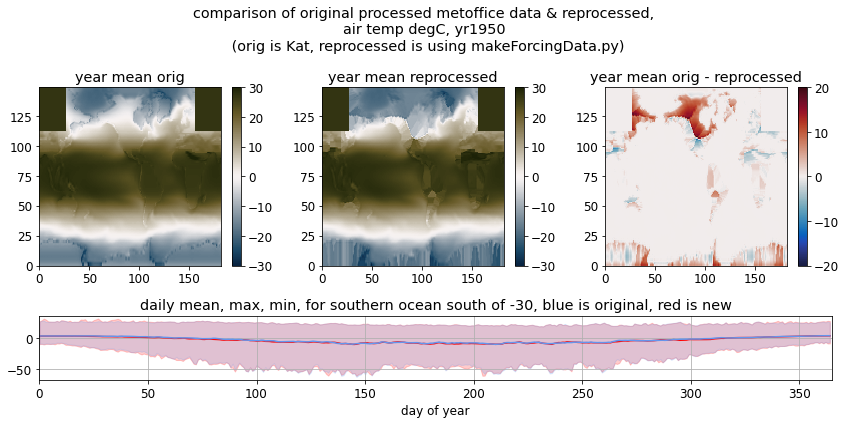

In [124]:
newvar = 'air'
origvar = 'tair10m'
vnam = 'air temp degC'
adj = 273
tvmin = (273-30)-adj; tvmax = (273+30)-adj; diffmin = -20; diffmax = 20 
tcmap = cm.diff
Met_new = nc.Dataset('/gpfs/home/mep22dku/scratch/MET_soft/hist/u-bc370_hist/bulk_1950_16_met_daily.nc')
Met_orig = nc.Dataset('/gpfs/data/greenocean/software/products/MetOffice/withOzone//MetOffice_tair10m1950.nc')
plot_comps(Met_new, Met_orig, vnam, yr, adj, tvmin, tvmax, diffmin, diffmax, tcmap)

## Specific humidity

reprocessed
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): x(182), y(149), deptht(1), time_counter(365)
    variables(dimensions): float32 nav_lon(y,x), float32 nav_lat(y,x), float32 deptht(y,x), float32 time_counter(time_counter), float32 shum(time_counter,y,x)
    groups: 
kat pipeline
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): x(182), y(149), time_counter(365)
    variables(dimensions): float32 nav_lon(y,x), float32 nav_lat(y,x), float32 time_counter(time_counter), float64 qair10m(time_counter,y,x)
    groups: 


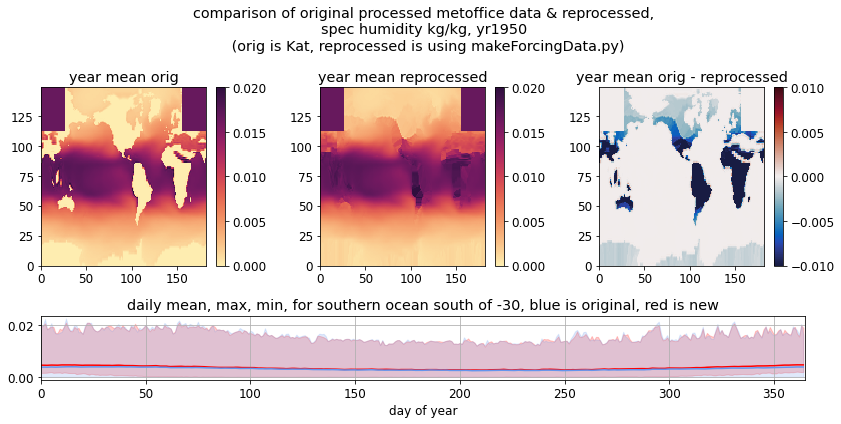

In [125]:
newvar = 'shum'
origvar = 'qair10m'
vnam = 'spec humidity kg/kg'
adj = 0
tvmin = 0; tvmax = 0.02; diffmin = -0.01; diffmax = 0.01 
tcmap = cm.matter
Met_new = nc.Dataset('/gpfs/home/mep22dku/scratch/MET_soft/hist/u-bc370_hist/bulk_1950_17_met_daily.nc')
Met_orig = nc.Dataset('/gpfs/data/greenocean/software/products/MetOffice/withOzone//MetOffice_qair10m1950.nc')
print('reprocessed')
print(Met_new)
print('kat pipeline')
print(Met_orig)
plot_comps(Met_new, Met_orig, vnam, yr, adj, tvmin, tvmax, diffmin, diffmax, tcmap)

## Shortwave radiation

reprocessed
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): x(182), y(149), deptht(1), time_counter(365)
    variables(dimensions): float32 nav_lon(y,x), float32 nav_lat(y,x), float32 deptht(y,x), float32 time_counter(time_counter), float32 rsds(time_counter,y,x)
    groups: 
kat pipeline
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): x(182), y(149), time_counter(365)
    variables(dimensions): float32 nav_lon(y,x), float32 nav_lat(y,x), float32 time_counter(time_counter), float64 sw_down(time_counter,y,x)
    groups: 


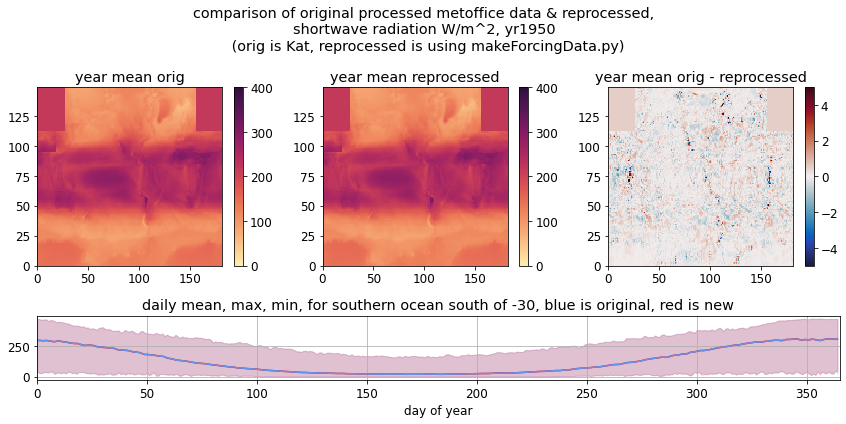

In [126]:
newvar = 'rsds'
origvar = 'sw_down'
vnam = 'shortwave radiation W/m^2'
adj = 0
tvmin = 0; tvmax = 400; diffmin = -5; diffmax = 5 
tcmap = cm.matter
Met_new = nc.Dataset('/gpfs/home/mep22dku/scratch/MET_soft/hist/u-bc370_hist/bulk_1950_18_met_daily.nc')
Met_orig = nc.Dataset('/gpfs/data/greenocean/software/products/MetOffice/withOzone//MetOffice_sw_down1950.nc')
print('reprocessed')
print(Met_new)
# print(Met_new[newvar])
print('kat pipeline')
print(Met_orig)
plot_comps(Met_new, Met_orig, vnam, yr, adj, tvmin, tvmax, diffmin, diffmax, tcmap)

## Longwave radiation 

reprocessed
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): x(182), y(149), deptht(1), time_counter(365)
    variables(dimensions): float32 nav_lon(y,x), float32 nav_lat(y,x), float32 deptht(y,x), float32 time_counter(time_counter), float32 rlds(time_counter,y,x)
    groups: 
kat pipeline
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): x(182), y(149), time_counter(365)
    variables(dimensions): float32 nav_lon(y,x), float32 nav_lat(y,x), float32 time_counter(time_counter), float64 lw_down(time_counter,y,x)
    groups: 


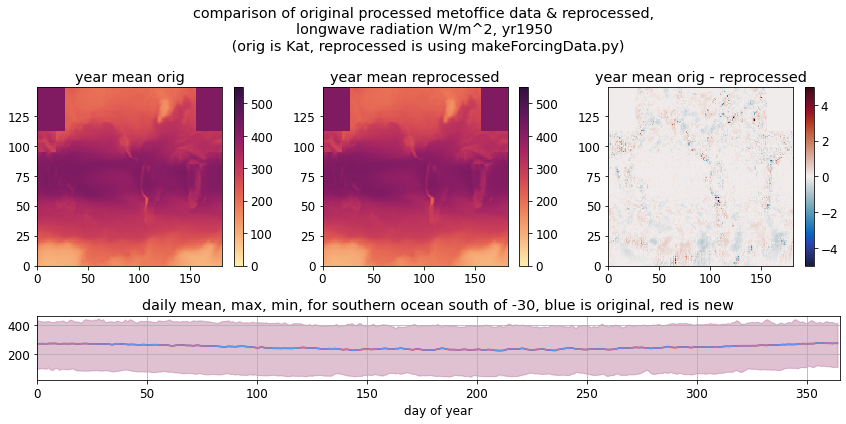

In [127]:
newvar = 'rlds'
origvar = 'lw_down'
vnam = 'longwave radiation W/m^2'
adj = 0
tvmin = 0; tvmax = 550; diffmin = -5; diffmax = 5 
tcmap = cm.matter
Met_new = nc.Dataset('/gpfs/home/mep22dku/scratch/MET_soft/hist/u-bc370_hist/bulk_1950_19_met_daily.nc')
Met_orig = nc.Dataset('/gpfs/data/greenocean/software/products/MetOffice/withOzone//MetOffice_lw_down1950.nc')
print('reprocessed')
print(Met_new)
# print(Met_new[newvar])
print('kat pipeline')
print(Met_orig)
plot_comps(Met_new, Met_orig, vnam, yr, adj, tvmin, tvmax, diffmin, diffmax, tcmap)

## Total precipitation 

reprocessed
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): x(182), y(149), deptht(1), time_counter(365)
    variables(dimensions): float32 nav_lon(y,x), float32 nav_lat(y,x), float32 deptht(y,x), float32 time_counter(time_counter), float32 prra(time_counter,y,x)
    groups: 
kat pipeline
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): x(182), y(149), time_counter(365)
    variables(dimensions): float32 nav_lon(y,x), float32 nav_lat(y,x), float32 time_counter(time_counter), float64 precip(time_counter,y,x)
    groups: 


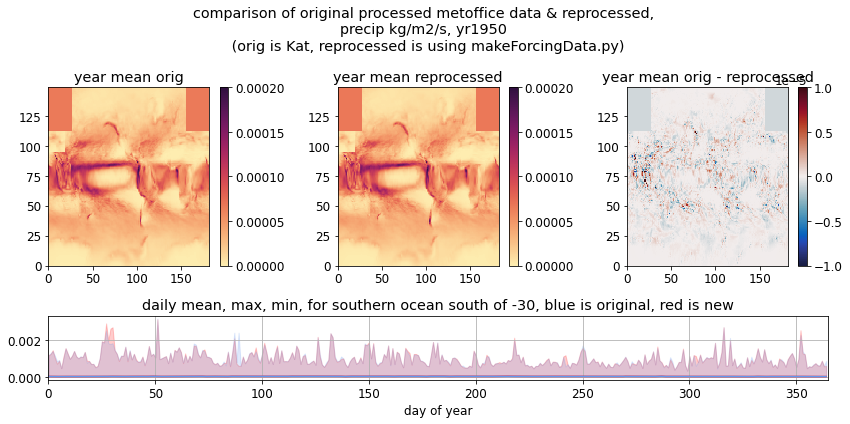

In [128]:
newvar = 'prra'
origvar = 'precip'
vnam = 'precip kg/m2/s'
adj = 0
tvmin = 0; tvmax = 0.0002; diffmin = -0.00001; diffmax =  0.00001 
tcmap = cm.matter
Met_new = nc.Dataset('/gpfs/home/mep22dku/scratch/MET_soft/hist/u-bc370_hist/bulk_1950_20_met_daily.nc')
Met_orig = nc.Dataset('/gpfs/data/greenocean/software/products/MetOffice/withOzone//MetOffice_precip1950.nc')
print('reprocessed')
print(Met_new)
# print(Met_new[newvar])
print('kat pipeline')
print(Met_orig)
plot_comps(Met_new, Met_orig, vnam, yr, adj, tvmin, tvmax, diffmin, diffmax, tcmap)

# Snow precipitation

In [ ]:
newvar = 'prsn'
origvar = 'snow'
vnam = 'snow kg/m2/s'
adj = 0
tvmin = 0; tvmax = 0.00005; diffmin = -0.000001; diffmax =  0.000001 
tcmap = cm.matter
Met_new = nc.Dataset('/gpfs/home/mep22dku/scratch/MET_soft/hist/u-bc370_hist/bulk_1950_21_met_daily.nc')
Met_orig = nc.Dataset('/gpfs/data/greenocean/software/products/MetOffice/withOzone//MetOffice_snow1950.nc')
print('reprocessed')
print(Met_new)
# print(Met_new[newvar])
print('kat pipeline')
print(Met_orig)
plot_comps(Met_new, Met_orig, vnam, yr, adj, tvmin, tvmax, diffmin, diffmax, tcmap)

reprocessed
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): x(182), y(149), deptht(1), time_counter(365)
    variables(dimensions): float32 nav_lon(y,x), float32 nav_lat(y,x), float32 deptht(y,x), float32 time_counter(time_counter), float32 prsn(time_counter,y,x)
    groups: 
kat pipeline
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): x(182), y(149), time_counter(365)
    variables(dimensions): float32 nav_lon(y,x), float32 nav_lat(y,x), float32 time_counter(time_counter), float64 snow(time_counter,y,x)
    groups: 


# wind uflx and vflx 

In [ ]:
newvar = 'uflx'
origvar = 'uwind10m'
vnam = 'uflx m/s'
adj = 0
tvmin = 0; tvmax = 10; diffmin = -2; diffmax =  2
tcmap = cm.matter

print('reprocessed')
Met_new = nc.Dataset('/gpfs/home/mep22dku/scratch/MET_soft/hist/u-bc370_hist/taux_1d_1950_daily.nc')
print(Met_new)
print('kat pipeline')
Met_orig = nc.Dataset('/gpfs/data/greenocean/software/products/MetOffice/withOzone/MetOffice_wind1950.nc')
print(Met_orig)


# # print(Met_new[newvar])


plot_comps(Met_new, Met_orig, vnam, yr, adj, tvmin, tvmax, diffmin, diffmax, tcmap)

In [ ]:
newvar = 'vflx'
origvar = 'vwind10m'
vnam = 'vflx m/s'
adj = 0
tvmin = 0; tvmax = 10; diffmin = -2; diffmax =  2
tcmap = cm.matter

print('reprocessed')
Met_new = nc.Dataset('/gpfs/home/mep22dku/scratch/MET_soft/hist/u-bc370_hist/tauy_1d_1950_daily.nc')
print(Met_new)
print('kat pipeline')
Met_orig = nc.Dataset('/gpfs/data/greenocean/software/products/MetOffice/withOzone/MetOffice_wind1950.nc')
print(Met_orig)


# # print(Met_new[newvar])


plot_comps(Met_new, Met_orig, vnam, yr, adj, tvmin, tvmax, diffmin, diffmax, tcmap)

In [ ]:
print('beep boop')